### Simple gradient computing with GradientTape

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print('gpu', gpu)
    tf.config.experimental.set_memory_growth(gpu, True)
    print('memory growth:' , tf.config.experimental.get_memory_growth(gpu))
import numpy as np
import matplotlib.pyplot as plt

gpu PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
memory growth: True


In [3]:
x = tf.Variable(3.0)

with tf.GradientTape() as tape:
    y = x**2

In [4]:
# dy = 2x * dx
dy_dx = tape.gradient(y,x)
dy_dx.numpy()

6.0

In [44]:
tf.random.set_seed(42)

In [50]:
w = tf.Variable(tf.random.normal((3,2)), name="w")
b = tf.Variable(tf.zeros(2, dtype=tf.float32), name="b")
x = [[1., 2.,3.]]

print(w.numpy())
print(b.numpy())
print(x)

with tf.GradientTape(persistent=True) as tape:
    y = x @ w + b
    #mean squared error
    loss = tf.reduce_mean(y**2)

[[ 0.0307604   0.29017973]
 [ 1.2829775   0.81271535]
 [-0.79449177  0.20022836]]
[0. 0.]
[[1.0, 2.0, 3.0]]


#### Gradient calculating

In [51]:
[d1_dw, d1_db] = tape.gradient(loss, [w,b]) 

In [52]:
print(w.shape)
print(d1_dw.shape)

(3, 2)
(3, 2)


### Gradient with respect to model

In [53]:
layer = tf.keras.layers.Dense(2, activation="relu")
x = tf.constant([[1., 2., 3.]])

with tf.GradientTape() as tape:
    #Forward pass
    y = layer(x)
    loss = tf.reduce_mean(y**2)
    
grad = tape.gradient(loss, layer.trainable_variables)

In [54]:
for var, g in zip(layer.trainable_variables, grad):
    print(f'{var.name}, shape: {g.shape}')

dense/kernel:0, shape: (3, 2)
dense/bias:0, shape: (2,)


#### with training a MNIST model

In [65]:
# Fetch and format the mnist data
(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()

dataset = tf.data.Dataset.from_tensor_slices(
  (tf.cast(mnist_images[...,tf.newaxis]/255, tf.float32),
   tf.cast(mnist_labels,tf.int64)))
dataset = dataset.shuffle(1000).batch(32)

In [66]:
mnist_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, [3,3], activation="relu", input_shape=(None, None, 1)),
    tf.keras.layers.Conv2D(16, [3,3], activation="relu"),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10)
])

In [67]:
for images,labels in dataset.take(1):
  print("Logits: ", mnist_model(images[0:1]).numpy())

Logits:  [[-0.03567188  0.00389965 -0.0690142   0.00060015 -0.00198655  0.02004649
   0.03739779 -0.03026259  0.00290774 -0.00036233]]


In [68]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

loss_history = []

In [69]:
def train_step(images, labels):
    with tf.GradientTape() as tape:
        logits = mnist_model(images, training=True)
        
        # Add asserts to check the shape of the output.
        tf.debugging.assert_equal(logits.shape, (32, 10))
        
        loss_value = loss_object(labels, logits)
        
    loss_history.append(loss_value.numpy().mean())
    grads = tape.gradient(loss_value, mnist_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, mnist_model.trainable_variables))

In [73]:
def train(epochs):
    for epoch in range(epochs):
        for (batch, (images, labels)) in enumerate(dataset):
            train_step(images, labels)
        print('Epoch {} finished'.format(epoch))

In [74]:
train(epochs=3)

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished


Text(0, 0.5, 'Loss [entropy]')

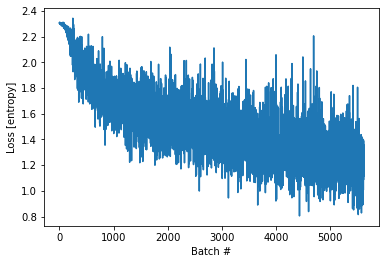

In [75]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')